# Fine-Tuning GPT-2 on IMDb Movie Reviews (Supervised Fine-Tuning)

In this section, I fine-tune a GPT-2 model on the full IMDb movie review dataset. This stage corresponds to the **Supervised Fine-Tuning (SFT)** part of the project, where the goal is to train GPT-2 to write text in the style of real movie reviews. Using the complete reviews (not summaries) helps the model pick up the natural flow, vocabulary, and structure found in long-form user reviews.

**Key choices for this stage:**

- **Dataset:** I use the full IMDb review text so the model learns to generate complete reviews rather than short summaries.
- **Training setup:** I rely on the Hugging Face *Trainer* API since it takes care of batching, gradient accumulation, evaluation, and saving checkpoints, which makes the workflow much smoother.
- **Model:** I fine-tune **GPT-2 Medium (355M parameters)**. With mixed-precision (FP16), it fits on the GPU and produces noticeably better generations than the smaller 124M version.
- **Logging:** Training metrics are logged to **Weights & Biases (wandb)**, and I also generate local Matplotlib plots of the loss curves for the report.
- **Evaluation:** Besides loss, I track next-token accuracy. This number is naturally small because of the large vocabulary, but it still gives a sense of whether the model is improving during training.

By the end of this stage, I obtain a fine-tuned GPT-2 Medium checkpoint and generate several sample reviews to see how well the model learned the writing style.

---


## Environment Setup

In [1]:
# !pip install transformers datasets wandb -q

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, set_seed
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're using a GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Initialize wandb (Weights & Biases)
import wandb
wandb.login() 

# Set a seed for reproducibility
set_seed(42)


Using device: cuda


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mah3i-tabesh500 (mah3i-tabesh500-mahdi-saleh-tabesh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Loading and Preparing the IMDb Dataset

Here I load the IMDb dataset and split the original training portion into a training set and a smaller validation set. A 90/10 split is enough to track overfitting while keeping most of the data for training. I also display a sample review to confirm that the dataset was loaded correctly.


In [3]:
# Load the IMDb dataset
raw_datasets = load_dataset("imdb")

# Split the IMDb training portion into train/validation (90% / 10%)
raw_train = raw_datasets["train"]
train_test_split = raw_train.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"] 

print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")

# Inspect a sample review from the training set
print("\nExample review:\n", train_dataset[0]["text"][:200], "...")
print("Label:", train_dataset[0]["label"])


Total training samples: 22500
Total validation samples: 2500

Example review:
 With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old  ...
Label: 0


## Tokenization and Chunk Preparation

In this part of the workflow, I tokenize the IMDb reviews using the GPT-2 tokenizer and reorganize the text into fixed-length blocks. Since GPT-2 is trained with a causal language-modeling objective, I merge each review into a continuous token stream and then split it into 512-token chunks. Any leftover tokens that don't fit cleanly into a full block are dropped to keep the input shape consistent.

Each chunk serves as a training example where the model learns to predict the next token at every position. The labels are therefore identical to the input token IDs. This format matches the original GPT-2 training setup and works well for supervised fine-tuning.


In [4]:
model_name = "gpt2-medium"  # GPT-2 Medium variant
tokenizer = AutoTokenizer.from_pretrained(model_name)

# GPT-2 has no pad token by default, so use EOS token as pad for our purpose
tokenizer.pad_token = tokenizer.eos_token

# Define the block size (sequence length for training examples)
block_size = 512

# Tokenization function for the dataset
def tokenize_function(examples):
    texts = examples["text"]
    # Tokenize each review with truncation; padding will be handled later by the data collator
    return tokenizer(texts, return_special_tokens_mask=False)

# Apply tokenization to the train and validation datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text", "label"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text", "label"])

# Function to group tokens into blocks of size block_size
def group_texts(examples):
    # Concatenate all token lists in this batch together
    concatenated = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated["input_ids"])
    # Drop the remainder so we have an integer multiple of block_size
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split the concatenated list of tokens into chunks of block_size
    result = {}
    for k, t in concatenated.items():
        result[k] = [t[i : i + block_size] for i in range(0, total_length, block_size)]
    # For language modeling, the labels are the same as the input (we want to predict every token)
    result["labels"] = result["input_ids"].copy()
    return result

# Group the tokenized data into fixed-length sequences
lm_train = tokenized_train.map(group_texts, batched=True, batch_size=1000)
lm_val = tokenized_val.map(group_texts, batched=True, batch_size=1000)

print(f"After grouping: {len(lm_train)} training chunks, {len(lm_val)} validation chunks")
print("Example of tokenized chunk:", lm_train[0]["input_ids"][:20])


After grouping: 13194 training chunks, 1427 validation chunks
Example of tokenized chunk: [3152, 777, 661, 277, 868, 523, 867, 6934, 11, 1262, 1468, 9640, 11, 290, 308, 19696, 4695, 284, 651, 606]


## Model Setup and Training Configuration

With the dataset prepared, the next step is to load the GPT-2 Medium model and define the training setup. I first resize the token embeddings so the model can use the tokenizer’s padding token, since GPT-2 does not include one by default. This prevents padding issues when batching variable-length sequences.

The training configuration is organized through `TrainingArguments`. These settings specify how the model is optimized and how progress is monitored. I use a small per-device batch size and rely on gradient accumulation to reach a stable effective batch size that fits on the GPU. Mixed-precision (FP16) is enabled to reduce memory usage and speed up computation. Evaluation and checkpoint saving happen once per epoch, which provides enough feedback without slowing training down.

Weights & Biases is used to log loss, perplexity, and other metrics during training, making it easy to review learning curves later. The data collator handles dynamic padding and prepares labels so that the model learns to predict the next token at every position—a requirement for causal language modeling.

Finally, the `Trainer` ties together the model, datasets, training arguments, and collator. This allows the entire training loop to run smoothly without needing to manually manage gradients, schedulers, or device placement.


In [5]:
model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))  # Ensure model can handle the added pad token if any

# Define training arguments
output_dir = "MiniGPT-RLHF/models/gpt2_imdb_sft_epoch5"
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    fp16=True, # use mixed precision
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    report_to="wandb", # report to wandb if logged in
    run_name="GPT2-IMDB-SFT",
    dataloader_num_workers=4, # speed up data loading
)

# Data collator for language modeling 
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_train,
    eval_dataset=lm_val,
    data_collator=data_collator,
)


## Training the Model

With the configuration in place, I launch the supervised fine-tuning run. The `Trainer` handles the full training loop, including forward passes, gradient updates, evaluation at the end of each epoch, and logging to Weights & Biases. After training completes, I save both the final model and the tokenizer to the output directory to ensure the checkpoint is fully preserved. I also record the training metrics returned by the `train()` call so they can be used later for analysis and reporting.


In [6]:
# Start the training
train_result = trainer.train()

# Save the final model
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

# Store the training metrics
train_metrics = train_result.metrics
print("Training finished. Logged metrics:", train_metrics)


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,3.336800,3.274118
2,3.235800,3.254743
3,3.159700,3.248262
4,3.106900,3.249495
5,3.063500,3.250953


Training finished. Logged metrics: {'train_runtime': 9786.8773, 'train_samples_per_second': 6.741, 'train_steps_per_second': 0.421, 'total_flos': 6.126638481801216e+16, 'train_loss': 3.185953261866714, 'epoch': 5.0}


## Tracking Loss and Perplexity

After training, I extract the logs recorded by the `Trainer` to analyze how the model behaved during optimization. The log history contains both training loss (recorded every few steps) and validation loss (recorded at the end of each epoch). Separating these makes it easier to visualize how quickly the model converged and whether it began to overfit.

Perplexity is computed by exponentiating the loss values. Although it can be sensitive to long-tail tokens, it still provides a useful sense of how well the model predicts the next token on average. I report both the final validation perplexity and the approximate perplexity based on the last logged training loss.

Finally, I plot the training and validation loss curves to get a clearer picture of the learning dynamics. This helps confirm that the model is improving steadily and that the evaluations align with the trends seen during training.


Final evaluation loss: 3.2510
Final evaluation perplexity: 25.81
Last logged training loss: 3.0635
Approx. training perplexity at end: 21.40


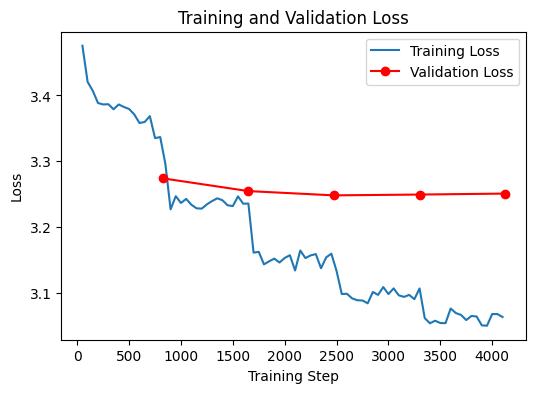

In [7]:
# Extract training loss values logged during training
history = trainer.state.log_history

# Separate out the training loss (logged at intervals) and evaluation loss (at epoch end)
train_loss_vals = []
train_loss_steps = []
eval_loss_vals = []
eval_loss_epochs = []

for log in history:
    if "loss" in log and "learning_rate" in log:  # training log entry (has loss and lr)
        train_loss_vals.append(log["loss"])
        train_loss_steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss_vals.append(log["eval_loss"])
        # log may have either 'step' or 'epoch' to indicate when eval happened
        if "step" in log:
            eval_loss_epochs.append(log["step"])
        elif "epoch" in log:
            # use epoch count (convert to step count or use as label)
            eval_loss_epochs.append(log["epoch"])

# Compute perplexities for final eval loss
if eval_loss_vals:
    final_eval_perplexity = np.exp(eval_loss_vals[-1])
    print(f"Final evaluation loss: {eval_loss_vals[-1]:.4f}")
    print(f"Final evaluation perplexity: {final_eval_perplexity:.2f}")
if train_loss_vals:
    final_train_perplexity = np.exp(train_loss_vals[-1])
    print(f"Last logged training loss: {train_loss_vals[-1]:.4f}")
    print(f"Approx. training perplexity at end: {final_train_perplexity:.2f}")

# Plot training loss over steps
plt.figure(figsize=(6,4))
plt.plot(train_loss_steps, train_loss_vals, label="Training Loss")
if eval_loss_vals:
    # Mark evaluation loss at epoch(s)
    plt.plot(eval_loss_epochs, eval_loss_vals, 'o-', color='red', label="Validation Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


## Next-Token Prediction Accuracy

To complement the loss and perplexity metrics, I also compute a simple next-token accuracy score on small samples from the training and validation sets. This metric checks how often the model’s most likely prediction matches the true next token. Although accuracy is naturally low for large-vocabulary language models, it still provides a useful sanity check on whether the model is improving and behaving consistently on seen and unseen data.

For this evaluation, I randomly sample a subset of sequences and run the model in inference mode. Predictions are compared token-by-token against the labels, ignoring any padding positions. The final accuracy values help illustrate the gap between training and validation performance and give an additional perspective on how well the model has adapted to the IMDb review domain.


In [8]:
# Calculate next-token prediction accuracy on a subset of the training data and validation data
# We will take a sample of 1000 sequences from training and validation for this evaluation.
import math

def compute_accuracy(model, dataset, sample_size=1000):
    model.eval()
    if sample_size > len(dataset):
        sample_size = len(dataset)
    # pick a subset of indices to evaluate
    indices = np.random.choice(len(dataset), size=sample_size, replace=False)
    subset = [dataset[i] for i in indices]
    # Create batches for computation
    batch_size = 8
    correct = 0
    total = 0
    for i in range(0, sample_size, batch_size):
        batch = subset[i: i+batch_size]
        # Prepare tensors
        input_ids = torch.tensor([item["input_ids"] for item in batch]).to(device)
        labels = torch.tensor([item["labels"] for item in batch]).to(device)
        # Get model predictions
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits  # shape: (batch, seq_len, vocab_size)
        # Predicted token is the one with highest logit
        predictions = logits.argmax(dim=-1)
        # Compare to labels (we need to ignore padding positions where label == -100 if present)
        if labels.dim() < 2:
            # ensure labels shape is (batch, seq_len)
            labels = labels.view(predictions.shape)
        mask = labels != -100  # in case padding tokens have label -100
        # Count correct where predictions match labels and mask is True
        match = (predictions == labels) & mask
        correct += match.sum().item()
        total += mask.sum().item()
    return correct / total

# Use the fine-tuned model (on GPU) for accuracy computation
model.to(device)
train_acc = compute_accuracy(model, lm_train, sample_size=1000)
val_acc = compute_accuracy(model, lm_val, sample_size=1000)
print(f"Next-token accuracy on 1000 training tokens: {train_acc*100:.2f}%")
print(f"Next-token accuracy on 1000 validation tokens: {val_acc*100:.2f}%")


Next-token accuracy on 1000 training tokens: 0.02%
Next-token accuracy on 1000 validation tokens: 0.08%


## Generating Sample Reviews

To see how the fine-tuned model writes after training, I run a few short prompts through the generator. Each prompt is expanded into a short continuation that reflects the style and patterns the model learned from the IMDb reviews. I enable nucleus sampling (top-p) and top-k filtering so the outputs are varied and not overly deterministic. The goal here is not to evaluate quality numerically, but simply to get a qualitative sense of how well the model has absorbed the review-writing style.

I generate several examples using different starting phrases and print the continuations for inspection. This helps verify that the model produces coherent text, stays on topic, and follows the tone implied by the prompt.


In [9]:
# Move model to CPU for generation if GPU memory is limited
model.to("cpu")

# Define prompts for generation
prompts = [
    "The movie was",
    "I absolutely loved this movie because",
    "This film was terrible. I hated"
]

# Generation parameters
generation_kwargs = {
    "max_length": 100,
    "num_return_sequences": 1,
    "do_sample": True,
    "top_p": 0.95,
    "top_k": 50,
    "temperature": 1.0
}

for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    # Generate continuation
    output_ids = model.generate(input_ids, **generation_kwargs)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Prompt: {prompt}")
    print(f"Generated continuation: {generated_text[len(prompt):]}")
    print("-" * 80)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: The movie was
Generated continuation:  an instant success and I was hooked from the moment I watched it. I think it's not a genre movie to be taken lightly and while it has a few things wrong with it I think the story lines are so deep and the acting superb that the movie deserves no such criticism.<br /><br />I'd like to suggest to anyone who hasn't seen it yet that they check it out. It's a very good movie and I encourage anybody to see it.There have been
--------------------------------------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: I absolutely loved this movie because
Generated continuation:  it kept you in the mood with the events and the characters, but the movie wasn't a total bust either. There were a few funny parts, but most of the movie revolved around those scenes, not the movie. It's a really great film with a great cast of people I really admire, but the story line is totally random and could have been great! Overall, I recommend this movie and try to avoid this one in the long run if it's out
--------------------------------------------------------------------------------
Prompt: This film was terrible. I hated
Generated continuation:  the script and the acting of the actors. I was very angry that I had spent money on this dreck. The ending was so stupid. I can't remember if I actually laughed or not. I would have enjoyed watching this movie. I'm just glad I didn't.I've only seen it on Turner Classic Movies but the trailer seemed promising. This is a strange film, so bizarre that I don't know 

In [11]:
model_size = sum(p.numel() for p in model.parameters())
print(f"Total GPT-2 parameters: {model_size:,}")

Total GPT-2 parameters: 354,823,168
